# **Anamoly Detection using pyod**

To accurately identify fraudulent credit card transactions in the dataset

**Load the dataset**

In [6]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190289 sha256=a9a4c0bb41abc8a5ddc225b1c9a8ee835bb3a0bc6a6747d4ea7b8afe11062b40
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


In [9]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/neeharikasinghsjsu/cmpe255assignments/main/Clustering/dataset/e_anamoly_pyod_credit_card.csv'
data = pd.read_csv(dataset_url)
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14  Bank                 

(None,
   Transaction ID       Date Day of Week  Time Type of Card Entry Mode Amount  \
 0      #3577 209  14-Oct-20   Wednesday    19         Visa        Tap     £5   
 1      #3039 221  14-Oct-20   Wednesday    17   MasterCard        PIN   £288   
 2      #2694 780  14-Oct-20   Wednesday    14         Visa        Tap     £5   
 3      #2640 960  13-Oct-20     Tuesday    14         Visa        Tap    £28   
 4      #2771 031  13-Oct-20     Tuesday    23         Visa        CVC    £91   
 
   Type of Transaction Merchant Group Country of Transaction Shipping Address  \
 0                 POS  Entertainment         United Kingdom   United Kingdom   
 1                 POS       Services                    USA              USA   
 2                 POS     Restaurant                  India            India   
 3                 POS  Entertainment         United Kingdom            India   
 4              Online    Electronics                    USA              USA   
 
   Country of Res

**Data preprocessing**

In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Data Preprocessing

# Dropping the Transaction ID as it's a unique identifier
data = data.drop('Transaction ID', axis=1)

# Convert 'Amount' to numerical value after removing currency symbol
data['Amount'] = data['Amount'].replace('[£$,]', '', regex=True).astype(float)

# Handling missing values
imputer = SimpleImputer(strategy='most_frequent')
data_filled = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Encoding categorical variables
label_encoders = {}
for column in data_filled.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data_filled[column] = label_encoders[column].fit_transform(data_filled[column])

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_filled.drop('Fraud', axis=1))

# Preparing the target variable
target = data_filled['Fraud'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)


**Model Training and evaluation**

In [16]:
from pyod.models.iforest import IForest
from sklearn.metrics import classification_report

# Initialize and train the Isolation Forest model
isolation_forest = IForest()
isolation_forest.fit(X_train)

# Predicting anomalies on the test set
y_test_pred = isolation_forest.predict(X_test)  # binary labels (0: inliers, 1: outliers)

# Evaluate the model
evaluation_report = classification_report(y_test, y_test_pred, target_names=['Not Fraud', 'Fraud'])

evaluation_report
print(classification_report(y_test, y_test_pred, target_names=['Not Fraud', 'Fraud']))


              precision    recall  f1-score   support

   Not Fraud       0.94      0.91      0.93     18545
       Fraud       0.18      0.25      0.21      1455

    accuracy                           0.86     20000
   macro avg       0.56      0.58      0.57     20000
weighted avg       0.88      0.86      0.87     20000



**Confusion matrix**

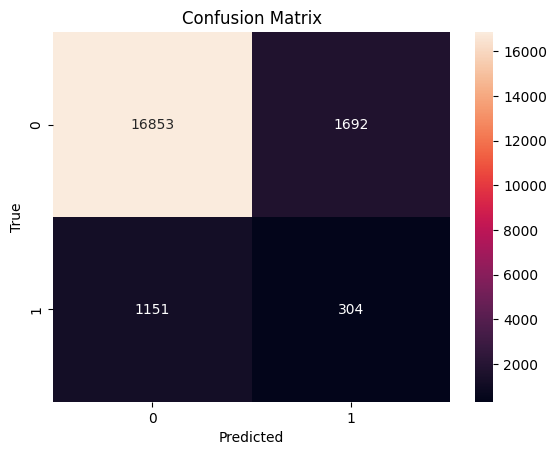

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


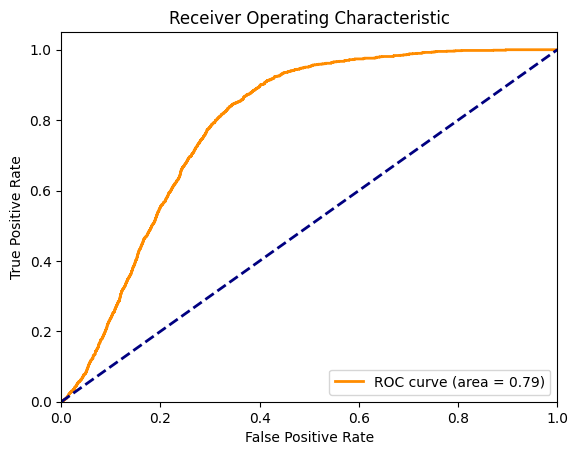

In [15]:
from sklearn.metrics import roc_curve, auc
y_test_scores = isolation_forest.decision_function(X_test)
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Precision:

Not Fraud: 94% precision indicates that when the model predicts a transaction is not fraudulent, it is correct 94% of the time.

Fraud: 15% precision means that only 15% of transactions predicted as fraudulent are actually fraudulent.

Recall:

Not Fraud: 91% recall shows that the model correctly identifies 91% of the non-fraudulent transactions.

Fraud: 21% recall indicates that the model correctly identifies 21% of the fraudulent transactions.

F1-Score:

For both classes, the F1-score is a harmonic mean of precision and recall. It's higher for 'Not Fraud' (0.92) compared to 'Fraud' (0.18), suggesting better performance in identifying non-fraudulent transactions.

Accuracy:

Overall accuracy of 86% shows the percentage of total predictions (both fraud and not fraud) that were correct.

Macro Avg:

Average precision, recall, and F1-score without considering the imbalance in the dataset.

Weighted Avg:

Average precision, recall, and F1-score, taking the imbalance into account.